In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
class Focus(nn.Module):
    def __init__(self,input_dims):
        super(Focus,self).__init__()
        self.input_dims = input_dims
        self.fc1 = nn.Linear(input_dims,1,bias=False)
    def forward(self,x):
        x = self.fc1(x)
        return x
        

In [3]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification,self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.fc1 = nn.Linear(input_dims,output_dims)
    def forward(self,x):
        
        x = self.fc1(x)
        if self.output_dims > 1:
            x = x
        else:
            x = torch.sigmoid(x)
        return x

In [4]:
def calculate_loss_focus(gamma,focus_output):
    #print(gamma.shape,focus_output.shape)
    log_outputs = torch.log(focus_output)
    
    loss_ = gamma*log_outputs
    loss_ = torch.sum(loss_,dim=1)
    loss_ = -torch.mean(loss_,dim=0)    
    return loss_ 
    

In [5]:
def calculate_loss_classification(gamma,classification_output,label,criterion,n_patches):
    
    batch = label.size(0)
    classes = classification_output.size(2)
    label = label.repeat_interleave(n_patches)
    classification_output = classification_output.reshape((batch*n_patches,classes))
    loss_ = criterion(classification_output,label)
    
    loss_ = loss_.reshape((batch,n_patches))
    
    loss_ = gamma*loss_
    loss_ = torch.sum(loss_,dim=1)
    loss_ = torch.mean(loss_,dim=0)
    
    return loss_
    

In [6]:
def expectation_step(fc,cl,data,labels):
    batch= data.size(0)
    with torch.no_grad():
        outputs_f = F.softmax(fc(data),dim=1)
        outputs_g = F.softmax(cl(data),dim=2)
        
    outputs_g = outputs_g[np.arange(batch),:,labels]
    p_x_y_z = outputs_f[:,:,0]*outputs_g   #(1-outputs_g)    
    normalized_p = p_x_y_z/torch.sum(p_x_y_z,dim=1,keepdims=True)
    return normalized_p

In [7]:
def maximization_step(p_z,focus,classification,data,labels,focus_optimizer,classification_optimizer,Criterion):    
    
    patches = data.size(1)
    focus_optimizer.zero_grad()
    classification_optimizer.zero_grad()
    
    focus_outputs = F.softmax(focus(data),dim=1)[:,:,0]
    classification_outputs = classification(data) # classification returns output after sigmoid/softmax
    
    
    #print(focus_outputs,classification_outputs)
    
    loss_focus = calculate_loss_focus(p_z,focus_outputs)
    loss_classification = calculate_loss_classification(p_z,classification_outputs,
                                                        labels,Criterion,patches)
    
    print("Focus loss",loss_focus.item())
    print("Classification loss",loss_classification.item())
    loss_focus.backward() 
    loss_classification.backward()
    focus_optimizer.step()
    classification_optimizer.step()
    
    return focus,classification,focus_optimizer,classification_optimizer

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 524.89it/s]


torch.Size([100, 100, 2]) torch.Size([100])


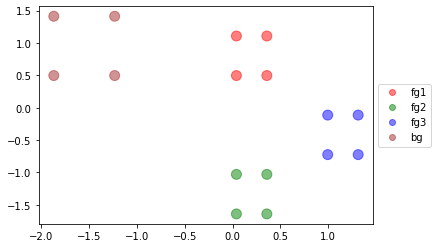

In [8]:
np.random.seed(12)
y = np.concatenate((np.zeros(4),np.ones(4),np.ones(4)*2,np.ones(4)*3))
idx= []
for i in range(4):
    #print(i,sum(y==i))
    idx.append(y==i)

    
x = np.zeros((16,2))



np.random.seed(12)
x[idx[0],:] = np.array([[5,4],[6,2],[5,2],[6,4]])

x[idx[1],:] = np.array([[5,-3],[5,-5],[6,-3],[6,-5]])
x[idx[2],:] = np.array([[8,-2],[8,0],[9,0],[9,-2]])
x[idx[3],:] = np.array([[1,2],[1,5],[-1,2],[-1,5]])

colors = ['red','green','blue','brown']

x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

plt.figure()
scatter = plt.scatter(x[:,0],x[:,1],c=y,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.5,s=100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))


desired_num = 100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)
    
    
data = np.transpose(np.dstack(mosaic_list_of_images),axes=(2,0,1))

data = torch.tensor(data,dtype=torch.float32)
labels = torch.tensor(mosaic_label)

print(data.shape,labels.shape)




In [9]:
# data[0],fore_idx[0],mosaic_label[0]

In [10]:
focus = Focus(2)
#print(focus.fc1.weight.data)
focus.fc1.weight.data = torch.tensor([[0.,0.]])
classification = Classification(2,3)
#print(classification.fc1.bias.data)
classification.fc1.weight.data = torch.tensor([[0.1,0.1],[-0.1,-0.1],[-0.1,0.]])
classification.fc1.bias.data = torch.tensor([0.,0.,0.])

Criterion = nn.CrossEntropyLoss(reduction="none") #nn.BCELoss(reduction="none")
focus_optimizer = optim.SGD(focus.parameters(), lr=0.5)
classification_optimizer = optim.SGD(classification.parameters(),lr=0.5)

for i in range(3000):
    p_z = expectation_step(focus,classification,data,labels)
    #print(p_z.shape)
    focus,classification,focus_optimizer,classification_optimizer=maximization_step(p_z
                                                                                ,focus,classification,data,
                                                                                labels,focus_optimizer,
                                                                                classification_optimizer,
                                                                                Criterion)
    
    

Focus loss 4.605170726776123
Classification loss 1.0870059728622437
Focus loss 4.605169773101807
Classification loss 1.0839719772338867
Focus loss 4.605170249938965
Classification loss 1.0835286378860474
Focus loss 4.605169773101807
Classification loss 1.0834224224090576
Focus loss 4.605169773101807
Classification loss 1.083371639251709
Focus loss 4.605169773101807
Classification loss 1.0833321809768677
Focus loss 4.605169773101807
Classification loss 1.0832948684692383
Focus loss 4.605170249938965
Classification loss 1.0832581520080566
Focus loss 4.605169773101807
Classification loss 1.0832210779190063
Focus loss 4.605169773101807
Classification loss 1.0831835269927979
Focus loss 4.605169773101807
Classification loss 1.0831454992294312
Focus loss 4.605169773101807
Classification loss 1.0831068754196167
Focus loss 4.605170249938965
Classification loss 1.0830676555633545
Focus loss 4.605170249938965
Classification loss 1.083027958869934
Focus loss 4.605169773101807
Classification loss 1

Focus loss 4.601871490478516
Classification loss 1.0726410150527954
Focus loss 4.6017231941223145
Classification loss 1.0724680423736572
Focus loss 4.601568222045898
Classification loss 1.072292447090149
Focus loss 4.601406574249268
Classification loss 1.0721137523651123
Focus loss 4.601238250732422
Classification loss 1.0719321966171265
Focus loss 4.601062297821045
Classification loss 1.0717475414276123
Focus loss 4.600878715515137
Classification loss 1.0715595483779907
Focus loss 4.600687026977539
Classification loss 1.0713683366775513
Focus loss 4.600487232208252
Classification loss 1.071174144744873
Focus loss 4.600278377532959
Classification loss 1.0709761381149292
Focus loss 4.600059986114502
Classification loss 1.0707744359970093
Focus loss 4.599831581115723
Classification loss 1.0705689191818237
Focus loss 4.599592685699463
Classification loss 1.0703598260879517
Focus loss 4.599343776702881
Classification loss 1.0701466798782349
Focus loss 4.5990824699401855
Classification loss

Focus loss 1.0548275709152222
Classification loss 0.1402348130941391
Focus loss 1.0531750917434692
Classification loss 0.13821564614772797
Focus loss 1.0515648126602173
Classification loss 0.13626928627490997
Focus loss 1.049993634223938
Classification loss 0.13439154624938965
Focus loss 1.0484580993652344
Classification loss 0.13257849216461182
Focus loss 1.046956181526184
Classification loss 0.13082654774188995
Focus loss 1.0454849004745483
Classification loss 0.12913240492343903
Focus loss 1.0440422296524048
Classification loss 0.1274930238723755
Focus loss 1.0426265001296997
Classification loss 0.12590555846691132
Focus loss 1.0412354469299316
Classification loss 0.12436728179454803
Focus loss 1.039867877960205
Classification loss 0.1228758916258812
Focus loss 1.0385220050811768
Classification loss 0.12142892181873322
Focus loss 1.037196397781372
Classification loss 0.12002431601285934
Focus loss 1.0358898639678955
Classification loss 0.11865998059511185
Focus loss 1.03460144996643

Focus loss 0.9259869456291199
Classification loss 0.05406235530972481
Focus loss 0.9253090023994446
Classification loss 0.053830336779356
Focus loss 0.9246340990066528
Classification loss 0.05360027402639389
Focus loss 0.9239621162414551
Classification loss 0.05337216705083847
Focus loss 0.9232926964759827
Classification loss 0.05314590781927109
Focus loss 0.9226261973381042
Classification loss 0.05292154848575592
Focus loss 0.9219623804092407
Classification loss 0.052699003368616104
Focus loss 0.9213014245033264
Classification loss 0.052478350698947906
Focus loss 0.920643150806427
Classification loss 0.05225945636630058
Focus loss 0.9199874401092529
Classification loss 0.052042361348867416
Focus loss 0.9193345904350281
Classification loss 0.05182705447077751
Focus loss 0.9186843633651733
Classification loss 0.051613472402095795
Focus loss 0.918036937713623
Classification loss 0.05140163376927376
Focus loss 0.9173921942710876
Classification loss 0.05119140446186066
Focus loss 0.9167501

Focus loss 0.8556885719299316
Classification loss 0.0342826321721077
Focus loss 0.8552772402763367
Classification loss 0.03418838232755661
Focus loss 0.8548673391342163
Classification loss 0.034094635397195816
Focus loss 0.8544586300849915
Classification loss 0.034001439809799194
Focus loss 0.8540511131286621
Classification loss 0.033908721059560776
Focus loss 0.8536449670791626
Classification loss 0.03381650522351265
Focus loss 0.8532401919364929
Classification loss 0.033724818378686905
Focus loss 0.8528366088867188
Classification loss 0.033633649349212646
Focus loss 0.8524343967437744
Classification loss 0.0335429422557354
Focus loss 0.8520333766937256
Classification loss 0.033452682197093964
Focus loss 0.851633608341217
Classification loss 0.033362988382577896
Focus loss 0.851235032081604
Classification loss 0.03327373415231705
Focus loss 0.8508378863334656
Classification loss 0.033184971660375595
Focus loss 0.8504417538642883
Classification loss 0.033096667379140854
Focus loss 0.85

Focus loss 0.8092939853668213
Classification loss 0.024952439591288567
Focus loss 0.8090090155601501
Classification loss 0.02490280382335186
Focus loss 0.8087246417999268
Classification loss 0.02485334873199463
Focus loss 0.8084409832954407
Classification loss 0.024804070591926575
Focus loss 0.8081580400466919
Classification loss 0.02475503273308277
Focus loss 0.8078755736351013
Classification loss 0.024706173688173294
Focus loss 0.8075939416885376
Classification loss 0.024657482281327248
Focus loss 0.8073126077651978
Classification loss 0.02460901252925396
Focus loss 0.8070321679115295
Classification loss 0.024560723453760147
Focus loss 0.8067523241043091
Classification loss 0.024512646719813347
Focus loss 0.8064730763435364
Classification loss 0.02446475811302662
Focus loss 0.8061943054199219
Classification loss 0.024417037144303322
Focus loss 0.805916428565979
Classification loss 0.02436954900622368
Focus loss 0.8056389689445496
Classification loss 0.02432219311594963
Focus loss 0.8

Focus loss 0.7750487327575684
Classification loss 0.019584644585847855
Focus loss 0.7748315930366516
Classification loss 0.01955430395901203
Focus loss 0.7746149301528931
Classification loss 0.01952403597533703
Focus loss 0.7743985652923584
Classification loss 0.019493864849209785
Focus loss 0.7741826772689819
Classification loss 0.0194637980312109
Focus loss 0.7739671468734741
Classification loss 0.019433772191405296
Focus loss 0.773751974105835
Classification loss 0.019403904676437378
Focus loss 0.7735371589660645
Classification loss 0.019374137744307518
Focus loss 0.773322582244873
Classification loss 0.019344404339790344
Focus loss 0.7731085419654846
Classification loss 0.019314777106046677
Focus loss 0.7728947997093201
Classification loss 0.019285308197140694
Focus loss 0.7726813554763794
Classification loss 0.019255876541137695
Focus loss 0.7724682092666626
Classification loss 0.0192265622317791
Focus loss 0.7722556591033936
Classification loss 0.019197287037968636
Focus loss 0.7

Focus loss 0.751349687576294
Classification loss 0.016517167910933495
Focus loss 0.7511699199676514
Classification loss 0.016495712101459503
Focus loss 0.750990092754364
Classification loss 0.016474325209856033
Focus loss 0.7508106827735901
Classification loss 0.016452932730317116
Focus loss 0.75063157081604
Classification loss 0.016431652009487152
Focus loss 0.7504526376724243
Classification loss 0.016410430893301964
Focus loss 0.7502739429473877
Classification loss 0.016389256343245506
Focus loss 0.7500956058502197
Classification loss 0.01636810041964054
Focus loss 0.7499175071716309
Classification loss 0.016347050666809082
Focus loss 0.7497395277023315
Classification loss 0.016326019540429115
Focus loss 0.7495619058609009
Classification loss 0.016305075958371162
Focus loss 0.7493845224380493
Classification loss 0.016284173354506493
Focus loss 0.7492074370384216
Classification loss 0.016263313591480255
Focus loss 0.7490304708480835
Classification loss 0.01624252274632454
Focus loss 0

Focus loss 0.7276155352592468
Classification loss 0.013902920298278332
Focus loss 0.7274664044380188
Classification loss 0.01388782262802124
Focus loss 0.7273175120353699
Classification loss 0.013872742652893066
Focus loss 0.7271687388420105
Classification loss 0.013857678510248661
Focus loss 0.7270200252532959
Classification loss 0.013842680491507053
Focus loss 0.72687166929245
Classification loss 0.013827703893184662
Focus loss 0.7267234325408936
Classification loss 0.01381276361644268
Focus loss 0.7265753149986267
Classification loss 0.013797822408378124
Focus loss 0.7264273762702942
Classification loss 0.013782977126538754
Focus loss 0.726279616355896
Classification loss 0.013768120668828487
Focus loss 0.7261321544647217
Classification loss 0.013753324747085571
Focus loss 0.7259847521781921
Classification loss 0.013738545589148998
Focus loss 0.7258375287055969
Classification loss 0.013723778538405895
Focus loss 0.725690484046936
Classification loss 0.013709086924791336
Focus loss 0

Focus loss 0.7098345756530762
Classification loss 0.012206974439322948
Focus loss 0.709705114364624
Classification loss 0.0121953459456563
Focus loss 0.7095757126808167
Classification loss 0.012183809652924538
Focus loss 0.7094466686248779
Classification loss 0.012172260321676731
Focus loss 0.7093175649642944
Classification loss 0.012160723097622395
Focus loss 0.70918869972229
Classification loss 0.012149214744567871
Focus loss 0.7090598940849304
Classification loss 0.01213773526251316
Focus loss 0.7089312076568604
Classification loss 0.012126270681619644
Focus loss 0.7088027000427246
Classification loss 0.012114843353629112
Focus loss 0.7086743116378784
Classification loss 0.012103420682251453
Focus loss 0.7085460424423218
Classification loss 0.012092032469809055
Focus loss 0.7084179520606995
Classification loss 0.012080677784979343
Focus loss 0.7082899212837219
Classification loss 0.01206930261105299
Focus loss 0.7081620693206787
Classification loss 0.012057950720191002
Focus loss 0.

Focus loss 0.6934724450111389
Classification loss 0.0108211450278759
Focus loss 0.693358838558197
Classification loss 0.010812053456902504
Focus loss 0.693245530128479
Classification loss 0.01080299261957407
Focus loss 0.693132221698761
Classification loss 0.010793955065310001
Focus loss 0.6930190920829773
Classification loss 0.010784907266497612
Focus loss 0.6929059624671936
Classification loss 0.010775907896459103
Focus loss 0.6927928924560547
Classification loss 0.010766914114356041
Focus loss 0.6926800608634949
Classification loss 0.010757939890027046
Focus loss 0.6925672888755798
Classification loss 0.01074895728379488
Focus loss 0.6924545764923096
Classification loss 0.010740016587078571
Focus loss 0.6923419833183289
Classification loss 0.010731103830039501
Focus loss 0.6922296285629272
Classification loss 0.01072219293564558
Focus loss 0.6921171545982361
Classification loss 0.010713270865380764
Focus loss 0.6920047998428345
Classification loss 0.010704372078180313
Focus loss 0.6

Focus loss 0.6808539032936096
Classification loss 0.009855094365775585
Focus loss 0.6807513236999512
Classification loss 0.009847594425082207
Focus loss 0.6806489825248718
Classification loss 0.009840095415711403
Focus loss 0.6805467009544373
Classification loss 0.009832623414695263
Focus loss 0.6804444789886475
Classification loss 0.00982513464987278
Focus loss 0.680342435836792
Classification loss 0.009817705489695072
Focus loss 0.6802403330802917
Classification loss 0.009810256771743298
Focus loss 0.6801384091377258
Classification loss 0.009802835993468761
Focus loss 0.6800365447998047
Classification loss 0.009795388206839561
Focus loss 0.6799348592758179
Classification loss 0.00978798046708107
Focus loss 0.679833173751831
Classification loss 0.00978059135377407
Focus loss 0.679731547832489
Classification loss 0.009773219004273415
Focus loss 0.6796300411224365
Classification loss 0.009765826165676117
Focus loss 0.6795284748077393
Classification loss 0.009758461266756058
Focus loss 0

Focus loss 0.6677467823028564
Classification loss 0.008937434293329716
Focus loss 0.667654812335968
Classification loss 0.008931283839046955
Focus loss 0.6675627827644348
Classification loss 0.008925113826990128
Focus loss 0.6674709916114807
Classification loss 0.008918986655771732
Focus loss 0.6673793196678162
Classification loss 0.008912863209843636
Focus loss 0.6672875881195068
Classification loss 0.008906770497560501
Focus loss 0.6671959161758423
Classification loss 0.008900655433535576
Focus loss 0.6671042442321777
Classification loss 0.008894567377865314
Focus loss 0.6670128107070923
Classification loss 0.008888469077646732
Focus loss 0.6669213771820068
Classification loss 0.008882381953299046
Focus loss 0.6668300032615662
Classification loss 0.008876313455402851
Focus loss 0.6667386889457703
Classification loss 0.008870257996022701
Focus loss 0.6666474938392639
Classification loss 0.00886418018490076
Focus loss 0.6665562987327576
Classification loss 0.008858141489326954
Focus lo

Focus loss 0.6569278836250305
Classification loss 0.008240356110036373
Focus loss 0.656843900680542
Classification loss 0.008235153742134571
Focus loss 0.6567598581314087
Classification loss 0.008229927159845829
Focus loss 0.6566759347915649
Classification loss 0.00822470523416996
Focus loss 0.6565921306610107
Classification loss 0.008219522424042225
Focus loss 0.6565082669258118
Classification loss 0.008214332163333893
Focus loss 0.6564244031906128
Classification loss 0.008209172636270523
Focus loss 0.6563407182693481
Classification loss 0.008203987032175064
Focus loss 0.6562570333480835
Classification loss 0.008198811672627926
Focus loss 0.6561734676361084
Classification loss 0.008193663321435452
Focus loss 0.6560897827148438
Classification loss 0.008188514970242977
Focus loss 0.6560063362121582
Classification loss 0.008183331228792667
Focus loss 0.6559228301048279
Classification loss 0.008178213611245155
Focus loss 0.6558395624160767
Classification loss 0.008173059672117233
Focus lo

Focus loss 0.6471633315086365
Classification loss 0.0076544759795069695
Focus loss 0.6470859050750732
Classification loss 0.0076499925926327705
Focus loss 0.6470084190368652
Classification loss 0.007645501289516687
Focus loss 0.6469310522079468
Classification loss 0.007641016039997339
Focus loss 0.6468538641929626
Classification loss 0.007636567577719688
Focus loss 0.6467767357826233
Classification loss 0.007632073014974594
Focus loss 0.6466995477676392
Classification loss 0.007627599872648716
Focus loss 0.6466223001480103
Classification loss 0.00762314535677433
Focus loss 0.6465451717376709
Classification loss 0.007618708070367575
Focus loss 0.6464681029319763
Classification loss 0.007614250760525465
Focus loss 0.6463912725448608
Classification loss 0.007609779946506023
Focus loss 0.646314263343811
Classification loss 0.007605364546179771
Focus loss 0.6462374329566956
Classification loss 0.007600925397127867
Focus loss 0.6461606621742249
Classification loss 0.007596501614898443
Focus 

Focus loss 0.6385048031806946
Classification loss 0.007166984491050243
Focus loss 0.6384327411651611
Classification loss 0.007163041736930609
Focus loss 0.6383609175682068
Classification loss 0.007159126456826925
Focus loss 0.638289213180542
Classification loss 0.007155197206884623
Focus loss 0.6382172107696533
Classification loss 0.007151307072490454
Focus loss 0.6381455063819885
Classification loss 0.00714737456291914
Focus loss 0.6380738615989685
Classification loss 0.007143452763557434
Focus loss 0.6380021572113037
Classification loss 0.007139535620808601
Focus loss 0.6379306316375732
Classification loss 0.007135665509849787
Focus loss 0.6378589868545532
Classification loss 0.007131737656891346
Focus loss 0.6377874612808228
Classification loss 0.007127860561013222
Focus loss 0.6377159357070923
Classification loss 0.007123961579054594
Focus loss 0.6376445889472961
Classification loss 0.007120121736079454
Focus loss 0.6375731229782104
Classification loss 0.007116237189620733
Focus lo

Focus loss 0.629642128944397
Classification loss 0.006697224918752909
Focus loss 0.6295754909515381
Classification loss 0.006693796720355749
Focus loss 0.629508912563324
Classification loss 0.006690383423119783
Focus loss 0.6294423937797546
Classification loss 0.006686963606625795
Focus loss 0.6293758153915405
Classification loss 0.006683546118438244
Focus loss 0.6293094158172607
Classification loss 0.006680140271782875
Focus loss 0.6292428374290466
Classification loss 0.006676753982901573
Focus loss 0.6291763782501221
Classification loss 0.006673319730907679
Focus loss 0.6291100382804871
Classification loss 0.006669939961284399
Focus loss 0.6290438175201416
Classification loss 0.006666542962193489
Focus loss 0.6289774775505066
Classification loss 0.006663128267973661
Focus loss 0.6289112567901611
Classification loss 0.00665974011644721
Focus loss 0.6288449764251709
Classification loss 0.006656371522694826
Focus loss 0.6287788152694702
Classification loss 0.006652962416410446
Focus los

Focus loss 0.6213511824607849
Classification loss 0.006282949820160866
Focus loss 0.6212892532348633
Classification loss 0.006279974710196257
Focus loss 0.6212273240089417
Classification loss 0.006276941858232021
Focus loss 0.62116539478302
Classification loss 0.006273938342928886
Focus loss 0.6211034059524536
Classification loss 0.006270944606512785
Focus loss 0.6210416555404663
Classification loss 0.00626794621348381
Focus loss 0.6209797859191895
Classification loss 0.006264940369874239
Focus loss 0.6209180951118469
Classification loss 0.006261957809329033
Focus loss 0.6208562254905701
Classification loss 0.006258958484977484
Focus loss 0.6207945346832275
Classification loss 0.006255989894270897
Focus loss 0.620732843875885
Classification loss 0.006253005471080542
Focus loss 0.6206712126731873
Classification loss 0.006250025704503059
Focus loss 0.6206096410751343
Classification loss 0.006247041281312704
Focus loss 0.6205480694770813
Classification loss 0.00624407222494483
Focus loss 

Focus loss 0.6133918762207031
Classification loss 0.005906888283789158
Focus loss 0.6133341193199158
Classification loss 0.005904231686145067
Focus loss 0.6132763028144836
Classification loss 0.005901571363210678
Focus loss 0.6132186651229858
Classification loss 0.005898906383663416
Focus loss 0.613161027431488
Classification loss 0.005896270740777254
Focus loss 0.6131032705307007
Classification loss 0.005893625784665346
Focus loss 0.6130456328392029
Classification loss 0.005890993867069483
Focus loss 0.6129881143569946
Classification loss 0.005888313055038452
Focus loss 0.6129304766654968
Classification loss 0.005885698366910219
Focus loss 0.6128729581832886
Classification loss 0.005883072502911091
Focus loss 0.6128156185150146
Classification loss 0.00588043499737978
Focus loss 0.6127579808235168
Classification loss 0.00587781798094511
Focus loss 0.6127006411552429
Classification loss 0.005875168368220329
Focus loss 0.612643301486969
Classification loss 0.0058725569397211075
Focus los

Focus loss 0.6058513522148132
Classification loss 0.005569079425185919
Focus loss 0.605797290802002
Classification loss 0.0055666957050561905
Focus loss 0.6057432293891907
Classification loss 0.0055643427185714245
Focus loss 0.6056894063949585
Classification loss 0.005561998579651117
Focus loss 0.6056354641914368
Classification loss 0.005559640470892191
Focus loss 0.605581521987915
Classification loss 0.00555730564519763
Focus loss 0.6055276989936829
Classification loss 0.005554953124374151
Focus loss 0.6054738163948059
Classification loss 0.005552602931857109
Focus loss 0.6054200530052185
Classification loss 0.005550275556743145
Focus loss 0.6053662896156311
Classification loss 0.0055479202419519424
Focus loss 0.6053124070167542
Classification loss 0.005545570980757475
Focus loss 0.6052587628364563
Classification loss 0.00554325757548213
Focus loss 0.6052050590515137
Classification loss 0.005540919490158558
Focus loss 0.6051512956619263
Classification loss 0.005538569763302803
Focus l

Focus loss 0.5995015501976013
Classification loss 0.005297861061990261
Focus loss 0.5994506478309631
Classification loss 0.005295715760439634
Focus loss 0.5993996262550354
Classification loss 0.00529360119253397
Focus loss 0.599348783493042
Classification loss 0.00529146334156394
Focus loss 0.5992977619171143
Classification loss 0.00528935668990016
Focus loss 0.5992469191551208
Classification loss 0.005287208128720522
Focus loss 0.5991960763931274
Classification loss 0.005285121966153383
Focus loss 0.5991451740264893
Classification loss 0.005283002741634846
Focus loss 0.5990943312644958
Classification loss 0.005280863028019667
Focus loss 0.599043607711792
Classification loss 0.005278748460114002
Focus loss 0.5989927053451538
Classification loss 0.005276642274111509
Focus loss 0.5989420413970947
Classification loss 0.005274513736367226
Focus loss 0.5988912582397461
Classification loss 0.005272431764751673
Focus loss 0.5988405346870422
Classification loss 0.005270306020975113
Focus loss 

Focus loss 0.592251181602478
Classification loss 0.005002298392355442
Focus loss 0.5922034978866577
Classification loss 0.005000391509383917
Focus loss 0.5921557545661926
Classification loss 0.004998520482331514
Focus loss 0.5921080708503723
Classification loss 0.004996614530682564
Focus loss 0.5920604467391968
Classification loss 0.004994704853743315
Focus loss 0.592012882232666
Classification loss 0.004992826841771603
Focus loss 0.5919652581214905
Classification loss 0.004990941379219294
Focus loss 0.5919176340103149
Classification loss 0.004989034961909056
Focus loss 0.591870129108429
Classification loss 0.004987142514437437
Focus loss 0.5918225646018982
Classification loss 0.004985289182513952
Focus loss 0.5917750000953674
Classification loss 0.004983378108590841
Focus loss 0.5917274951934814
Classification loss 0.004981509875506163
Focus loss 0.5916799902915955
Classification loss 0.004979632329195738
Focus loss 0.591632604598999
Classification loss 0.004977756179869175
Focus loss

Focus loss 0.5858587026596069
Classification loss 0.004753628745675087
Focus loss 0.5858137011528015
Classification loss 0.004751934204250574
Focus loss 0.5857687592506409
Classification loss 0.004750232212245464
Focus loss 0.5857238173484802
Classification loss 0.004748511593788862
Focus loss 0.5856788754463196
Classification loss 0.004746841732412577
Focus loss 0.5856340527534485
Classification loss 0.00474511319771409
Focus loss 0.5855891704559326
Classification loss 0.004743412137031555
Focus loss 0.5855443477630615
Classification loss 0.004741712007671595
Focus loss 0.5854995250701904
Classification loss 0.004739990923553705
Focus loss 0.5854546427726746
Classification loss 0.004738300573080778
Focus loss 0.585409939289093
Classification loss 0.004736615810543299
Focus loss 0.5853650569915771
Classification loss 0.0047348979860544205
Focus loss 0.5853202939033508
Classification loss 0.00473319785669446
Focus loss 0.5852754712104797
Classification loss 0.0047315270639956
Focus loss

Focus loss 0.5805932283401489
Classification loss 0.004556889645755291
Focus loss 0.5805503129959106
Classification loss 0.004555329214781523
Focus loss 0.5805075168609619
Classification loss 0.004553766921162605
Focus loss 0.5804648399353027
Classification loss 0.004552186466753483
Focus loss 0.580422043800354
Classification loss 0.004550610203295946
Focus loss 0.5803792476654053
Classification loss 0.0045490507036447525
Focus loss 0.5803365111351013
Classification loss 0.0045474860817193985
Focus loss 0.5802938938140869
Classification loss 0.004545940086245537
Focus loss 0.5802512168884277
Classification loss 0.004544381983578205
Focus loss 0.5802085399627686
Classification loss 0.004542813170701265
Focus loss 0.5801658034324646
Classification loss 0.004541248548775911


In [11]:
focus_output = F.softmax(focus(data),dim=1)[:,:,0]
calculate_loss_focus(p_z,focus_output)

tensor(0.5802, grad_fn=<NegBackward>)

In [12]:
for params in focus.parameters():
    print(params)
    

Parameter containing:
tensor([[ 3.1580, -4.8366]], requires_grad=True)


In [13]:
for params in classification.parameters():
    print(params)

Parameter containing:
tensor([[-3.1013,  5.3973],
        [-3.8789, -5.6116],
        [ 6.8802,  0.2143]], requires_grad=True)
Parameter containing:
tensor([ 2.7426, -0.2903, -2.4523], requires_grad=True)


In [14]:
# focus(data)

# Evaluation


In [15]:
# method 1
batch = data.size(0)
indexes = torch.argmax(F.softmax(focus(data),dim=1),dim=1)[:,0].numpy()
print("Focus True",(np.sum(indexes == fore_idx,axis=0).item()/len(fore_idx))*100)
outputs = F.softmax(classification(data[np.arange(batch),indexes,:]),dim=1)
prediction = torch.argmax(outputs,dim=1)
accuracy = (torch.sum(prediction == labels,dim=0)/len(labels) )*100
print("Accuracy", accuracy.item())

Focus True 100.0
Accuracy 100.0


In [16]:
# method 2
focus_output = F.softmax(focus(data),dim=1)
indexes = torch.argmax(F.softmax(focus(data),dim=1),dim=1)[:,0].numpy()
classification_output = F.softmax(classification(data),dim=2)
print("Focus True",(np.sum(indexes == fore_idx,axis=0).item()/len(fore_idx))*100)
prediction = torch.argmax(torch.sum(focus_output*classification_output,dim=1),dim=1)
accuracy = (torch.sum(prediction == labels,dim=0)/len(labels) )*100
print("Accuracy", accuracy.item())

Focus True 100.0
Accuracy 100.0
